#### Load necessary packages

In [22]:
import numpy as np
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Load CMIP6 training data

In [2]:
with open('../data/cmip6_random_samples.pkl', 'rb') as f:
    cmip6_random_samples = pickle.load(f)

#### Transform mon to mon_sin and mon_cos

In [3]:
def sinus(month_index):
    return np.sin( month_index / 12 * 2 * np.pi)

def cosinus(month_index):
    return np.cos( month_index / 12 * 2 * np.pi)

In [4]:
cmip6_random_samples["mon_sin"] = sinus(cmip6_random_samples["mon"])
cmip6_random_samples["mon_cos"] = cosinus(cmip6_random_samples["mon"])
del cmip6_random_samples["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [5]:
cmip6_random_samples["nvector1"] = np.sin(cmip6_random_samples["lat"])
cmip6_random_samples["nvector2"] = np.sin(cmip6_random_samples["lon"])\
* np.cos(cmip6_random_samples["lat"])
cmip6_random_samples["nvector3"] = - np.cos(cmip6_random_samples["lon"])\
* np.cos(cmip6_random_samples["lat"])
del cmip6_random_samples["lon"]
del cmip6_random_samples["lat"]

In [6]:
df = pd.DataFrame(cmip6_random_samples)
print(df)

           talkos  dissicos        tos        sos          sios         po4os  \
0        0.002300  0.002075  14.205753  33.903896  1.275010e-05  1.933323e-08   
1        0.002299  0.001981  26.818392  34.373871  9.919313e-09  8.624555e-09   
2        0.002260  0.001934  27.420202  33.745064  5.357209e-08  7.909007e-08   
3        0.002324  0.002038  29.089867  34.708054  7.142363e-06  6.850541e-07   
4        0.002287  0.002104   8.901377  33.684261  2.263223e-05  6.110404e-07   
...           ...       ...        ...        ...           ...           ...   
5999995  0.002195  0.001886  28.419693  33.151085  2.099906e-07  1.963973e-07   
5999996  0.002301  0.002002  19.004026  35.086674  6.228225e-07  2.802442e-07   
5999997  0.002101  0.001810  28.489004  30.891163  4.541886e-07  9.149397e-10   
5999998  0.002292  0.002150  -0.870190  33.540627  8.180652e-05  1.530746e-06   
5999999  0.002307  0.001977  24.939692  35.061729  2.198318e-07  2.191912e-07   

            mlotst       zo

#### Normalize talkos, dissicos, tos, sos, sios, and po4os

In [7]:
alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

sample_means = {"talkos":(alk_range[0] + alk_range[1]) / 2,
                 "dissicos":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tos":(tem_range[0] + tem_range[1]) / 2,
                 "sos":(sal_range[0] + sal_range[1]) / 2,
                 "sios":(sil_range[0] + sil_range[1]) / 2,
                 "po4os":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"talkos":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dissicos":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tos":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sos":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sios":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "po4os":(phos_range[1] - phos_range[0]) / np.sqrt(12)}

label_keys = ["talkos", "dissicos", "tos", "sos", "sios", "po4os"]
for key in label_keys:
    cmip6_random_samples[key] = (
        cmip6_random_samples[key] - sample_means[key]) / sample_stds[key]

####  Split into training and validation sets,
#### normalize data and convert into feature and label arrays

In [9]:
np.random.seed(0)
nsamples = 6000_000
ntrain = 5000_000

random_indices = np.arange(nsamples, dtype=int)
random.shuffle(random_indices)

train_samples = {key: cmip6_random_samples[key][random_indices][:ntrain]
                 for key in cmip6_random_samples}
valid_samples = {key: cmip6_random_samples[key][random_indices][ntrain:]
                 for key in cmip6_random_samples}

In [10]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas", "pr",
                "clt", "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

In [12]:
train_feature_means = {key: np.mean(train_samples[key]) for key in feature_keys}
train_feature_stds = {key: np.std(train_samples[key]) for key in feature_keys}

train_features = np.concatenate([(
    train_samples[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

valid_features = np.concatenate([(
    valid_samples[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

train_labels = np.concatenate([train_samples[key][:, np.newaxis]
                                 for key in label_keys],
                                          axis=1)

valid_labels = np.concatenate([valid_samples[key][:, np.newaxis]
                                 for key in label_keys],
                                          axis=1)

In [13]:
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

(5000000, 16)
(1000000, 16)
(5000000, 6)
(1000000, 6)


In [14]:
print("Verify that features are normalized.")
print(np.mean(train_features, axis=0))
print(np.std(train_features, axis=0))
print(np.mean(valid_features, axis=0))
print(np.std(valid_features, axis=0))

Verify that features are normalized.
[-5.51687999e-08  9.36022487e-07  8.90589523e-08  1.29300851e-08
  1.16477028e-07 -1.53430300e-07 -1.80455975e-08  9.29011192e-09
 -1.71977156e-07 -2.40814426e-06 -1.26430477e-05 -1.13657033e-15
  3.29076255e-15 -1.03505662e-15 -3.16306314e-17 -2.67538325e-16]
[0.99999982 0.99999969 1.00000015 0.99999984 1.00000003 1.00000039
 0.99999958 1.00000012 0.99999975 1.00000004 0.99999987 1.
 1.         1.         1.         1.        ]
[ 2.45400780e-03 -5.23601797e-04 -1.47944369e-03  2.61007513e-03
 -2.15210529e-04 -1.71278481e-03 -1.42110571e-03 -6.27443566e-04
 -1.35819769e-04 -1.08722517e-03  1.34776250e-03  4.51753677e-04
 -8.19936782e-04 -5.33935058e-05  1.73444589e-04  3.39609559e-04]
[1.00021151 1.0018881  1.00176929 0.9990404  0.99496454 0.99811735
 1.00004913 0.99791581 1.00007563 1.00046483 1.00049685 1.00054979
 0.99945065 1.00026957 1.00047674 0.99898436]


#### Define neural network and training procedure

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2, device=self.device)
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3, device=self.device)
        self.linear4 = nn.Linear(hidden_size_3, output_size, device=self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = self.linear4(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

loss_function = nn.MSELoss()

In [16]:
model = MLP(16, 160, 160, 160, 6)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

MLP(
  (linear1): Linear(in_features=16, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=6, bias=True)
)
Number of trainable parameters in the model: 55206


In [17]:
def training_dataloader(features, labels, batch_size):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")),
                   torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")))
                  for ind in batch_indices]
    return batch_data

In [18]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch
    
    training_data = training_dataloader(train_features,
                                        train_labels, batch_size)
    
    for batch in training_data:
        features, labels = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features))
        loss = loss_function(outputs, labels.to(torch.device("cuda")))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [19]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, base_learning_rate, gamma, n_epochs):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    for epoch in pbar:

        model.train()
        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features.astype("float32"))))
            valid_loss_epoch = loss_function(valid_outputs, 
                                             torch.from_numpy(valid_labels).to(torch.device("cuda"))
                                            ).detach().cpu().item()
        
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss':f'{train_loss_epoch:.4e}',
                          'valid_loss':f'{valid_loss_epoch:.4e}',
                          'learn_rate':f'{lr:.4e}'})

    return train_stats

#### Train neural network with pytorch

In [20]:
batch_size = 1000
base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)
n_epochs = 10000
train_stats = train(batch_size, base_learning_rate, gamma, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:12:13<00:00,  5.11s/it, epoch=10000/10000, train_loss=7.5421e-04, valid_loss=8.5874e-04, learn_rate=1.0005e-05]


In [23]:
model.save("CMIP6_base_model_160x3_elu_10000epo.pth")

Text(0, 0.5, 'Mean squared error')

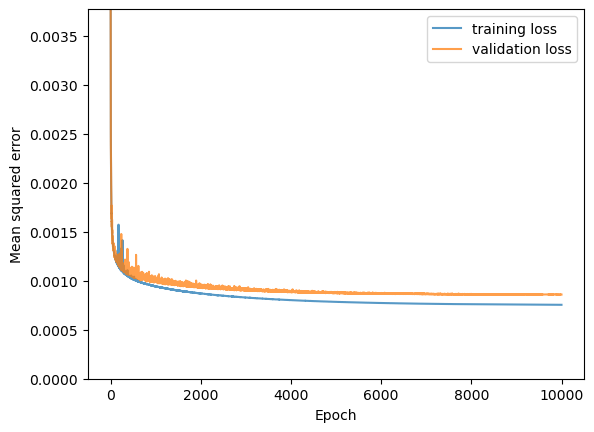

In [25]:
plt.plot(train_stats["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([0, train_stats["train_loss"][-1] * 5])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")

In [31]:
print("Valid loss at end of training close to overall minimum: {:.4e}".format(
    np.min(train_stats["valid_loss"])
))


Valid loss at end of training close to overall minimum: 8.5813e-04


In [36]:
print("Some tests of model performance")
print("Order:", "talkos", "dissicos", "tos", "sos", "sios", "po4os")
random_indices = np.random.randint(1000_000, size=10, dtype=int)

model.eval()
with torch.no_grad():
    for ind in random_indices:
        print("Index: ", ind)
        print(valid_labels[ind])
        print(model(torch.from_numpy(valid_features[ind, :].astype("float32"))))
        print("-----")

Some tests of model performance
Order: talkos dissicos tos sos sios po4os
Index:  514591
[ 0.45877597  1.21807539 -0.26870131  0.36895442 -1.68157378 -1.45488249]
tensor([ 0.4694,  1.2257, -0.2684,  0.3703, -1.6829, -1.4413], device='cuda:0')
-----
Index:  836298
[ 0.38236364  1.09177457  0.31853211  0.34501469 -1.50329423 -1.53240172]
tensor([ 0.3765,  1.0817,  0.3201,  0.3457, -1.5160, -1.5337], device='cuda:0')
-----
Index:  477428
[ 0.53569242  1.50586875 -1.3844775   0.34251451  0.14007419 -0.29894538]
tensor([ 0.5273,  1.4909, -1.3844,  0.3411,  0.0062, -0.3116], device='cuda:0')
-----
Index:  909463
[ 0.76221073  1.35260699  0.81415206  0.58116639 -1.73138363 -1.7154826 ]
tensor([ 0.7384,  1.3444,  0.8159,  0.5823, -1.7285, -1.7217], device='cuda:0')
-----
Index:  649891
[ 0.34954465  1.43475178 -1.70608342  0.25354031 -1.08619055  0.04507033]
tensor([ 0.3487,  1.3919, -1.7067,  0.2542, -1.1445, -0.1998], device='cuda:0')
-----
Index:  227838
[ 0.6197755   1.59320822 -1.4971627 

In [92]:
sample_means_array = np.concatenate([np.array(sample_means[key])[np.newaxis]
                                     for key in label_keys], axis=0)
sample_stds_array = np.concatenate([np.array(sample_stds[key])[np.newaxis]
                                    for key in label_keys], axis=0)

def denormalize(array):
    return array * sample_stds_array + sample_means_array

In [46]:
model.eval()
with torch.no_grad():
    for ind in random_indices:
        print("Index: ", ind)
        print(denormalize(valid_labels[ind]))
        print(denormalize(
            model(torch.from_numpy(valid_features[ind, :].astype("float32")
                                  )).detach().cpu().numpy()))
        print("-----")

Index:  514591
[2.26487443e-03 2.03712076e-03 1.36300066e+01 3.42603187e+01
 1.95257602e-06 3.20046403e-07]
[2.27102535e-03 2.04049006e-03 1.36334897e+01 3.42761155e+01
 1.90050170e-06 3.35721677e-07]
-----
Index:  836298
[2.22075775e-03 1.98142733e-03 1.99022351e+01 3.39838865e+01
 8.84886893e-06 2.30534907e-07]
[2.21736122e-03 1.97700630e-03 1.99186046e+01 3.39922550e+01
 8.35720197e-06 2.29061262e-07]
-----
Index:  477428
[2.30928216e-03 2.16402571e-03 1.71242358e+00 3.39550169e+01
 7.24184155e-05 1.65480761e-06]
[2.30441054e-03 2.15741219e-03 1.71337981e+00 3.39385835e+01
 6.72416142e-05 1.64013987e-06]
-----
Index:  909463
[2.44006257e-03 2.09644362e-03 2.51959419e+01 3.67107314e+01
 2.58078886e-08 1.91313162e-08]
[2.42629065e-03 2.09282191e-03 2.52147475e+01 3.67234269e+01
 1.37911637e-07 1.19196516e-08]
-----
Index:  649891
[ 2.20180970e-03  2.13266607e-03 -1.72264282e+00  3.29276313e+01
  2.49834689e-05  2.05204274e-06]
[ 2.20131090e-03  2.11375352e-03 -1.72896462e+00  3.293495

In [74]:
def MSE(x, y):
    return np.sum((x - y)**2, axis=0) / len(x)

In [78]:
model.eval()
with torch.no_grad():
    model_output_denormalized = denormalize(model(torch.from_numpy(
        valid_features.astype("float32"))).detach().cpu().numpy().squeeze())

valid_labels_denormalized = denormalize(valid_labels)

In [94]:
print("RMSE: talkos: {:.2e}, dissicos: {:.2e}, tos: {:.2e},\n"
"sos: {:.2e}, sios: {:.2e}, po4os: {:.2e}".format(
    *np.sqrt(MSE(model_output_denormalized, valid_labels_denormalized))))

RMSE: talkos: 1.07e-05, dissicos: 1.06e-05, tos: 1.62e-02,
sos: 2.37e-02, sios: 1.59e-06, po4os: 5.81e-08


In [95]:
print("Normalized max deviation:\n", np.max(np.abs(model_output - valid_labels), axis=0))
print("As expected: Precision for T and S much higher.")

Normalized max deviation:
 [1.41578569 1.59240614 0.05080688 0.03322437 1.74463643 1.49312639]
As expected: Precision for T and S much higher.


In [93]:
print("Max deviation: talkos: {:.2e}, dissicos: {:.2e}, tos: {:.2e},\n"
"sos: {:.2e}, sios: {:.2e}, po4os: {:.2e}".format(
    *np.max(np.abs(model_output_denormalized - valid_labels_denormalized), axis=0)))

Max deviation: talkos: 8.17e-04, dissicos: 7.02e-04, tos: 5.43e-01, 
sos: 3.84e-01, sios: 6.75e-05, po4os: 1.72e-06
